In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter

ModuleNotFoundError: No module named 'tensorboardX'

In [ ]:
lr = 1e-3
batch_size = 4
num_epoch = 100
data_dir = "C:/Users/hjane/Desktop/Git/Unet/data"
ckpt_dir = "C:/Users/hjane/Desktop/Git/Unet/checkpoint"
log_dir = "C:/Users/hjane/Desktop/Git/Unet/log"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the CPU


<img src="https://miro.medium.com/max/1200/1*qNdglJ1ORP3Gq77MmBLhHQ.png">

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__(self)
        
        def CBR2d(in_channnels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channnels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            
            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channnels=1, out_channels=64, kernel_size=3, stride=1, bias=True)
        self.enc1_2 = CBR2d(in_channnels=64, out_channels=64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channnels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channnels=128, out_channels=128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CBR2d(in_channnels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channnels=256, out_channels=256)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channnels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channnels=512, out_channels=512)
        
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channnels=512, out_channels=1024)
        
        # Expansive path
        self.dec5_1 = CBR2d(in_channnels=1024, out_channels=512)
        
        self.uppool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec4_2 = CBR2d(in_channnels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channnels=512, out_channels=256)
        
        self.uppool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec3_2 = CBR2d(in_channnels=2*256, out_channels=256)
        self.dec3_1 = CBR2d(in_channnels=256, out_channels=128)
        
        self.uppool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec2_2 = CBR2d(in_channnels=2*128, out_channels=128)
        self.dec2_1 = CBR2d(in_channnels=128, out_channels=64)
        
        self.uppool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec1_2 = CBR2d(in_channnels=2*64, out_channels=64)
        self.dec1_1 = CBR2d(in_channnels=64, out_channels=64)
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool(enc1_2)
        
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        
        enc5_1 = self.enc5_1(pool4)
        
        dec5_1 =self.dec5_1(enc5_1)
        
        uppool4 = self.uppool4(dec5_1)
        
        dec4_2 = self.dec4_2(torch.cat((uppool4, enc4_2), dim=1))
        dec4_1 = self.dec4_1(dec4_2)
        
        uppool3 = self.uppool3(dec4_1)
        
        dec3_2 = self.dec3_2(torch.cat((uppool3, enc3_2), dim=1))
        dec3_1 = self.dec3_1(dec3_2)
        
        uppool2 = self.uppool2(dec3_1)
        
        dec2_2 = self.dec2_2(torch.cat((uppool2, enc2_2), dim=1))
        dec2_1 =self.dec2_2(dec2_2)
        
        uppool1 = self.uppool1(dec2_1)
        
        dec1_2 = self.dec1_2(torch.cat((uppool1, enc1_2), dim=1))
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.fc(dec1_1)
        
        return x

kernel_size(Convolution의 view, 2차원에서는 대부분 3x3 pixel), stride(이미지를 스캔할 때 kernel의 step size), bias는 CBR layer를 구축하는데 있어 값이 고정됨 >> 이 값들이 뭐하는 얘들이지?
각각의 함수가 의미하는 transforms

In [ ]:
# DataLoader
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transfrom = transform
        
        lst_data = os.listdir(self.data_dir)
        
        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]
        
        lst_label.sort()
        lst_input.sort()
        
        self.lst_label = lst_label
        self.lst_input = lst_input
        
    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        
        label = label/255.0
        input = input/255.0
        
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]
        data = {'input': input, 'label': label}
        
        if self.transfrom:
            data = self.transform(data)
            
        return data

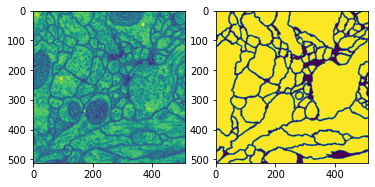

In [ ]:
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'))

data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

plt.subplot(121)
plt.imshow(input.squeeze())

plt.subplot(122)
plt.imshow(label.squeeze())


plt.show()

### Data transforms

In [ ]:
# Data transforms
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = label.transpose((2,0,1)).astype(np.float32)
        
        data = {'label': torch.from_numpy(label), 'input':torch.from_numpy(input)}
        
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std
        
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        input = (input - self.mean) / self.std
        
        data = {'label' : label, 'input' : input}
        
        return data
    
class RandomFlip(object):
    def __call__(self, data, probability=0.5):
        label, input = data['label'], data['input']
        
        if np.random.rand() < probability:
            label = np.fliplr(label)
            input = np.fliplr(input)
            
        if np.random.rand() < probability:
            label = np.flipud(label)
            input = np.flipud(label)
            
        data = {'label' : label, 'input': input}
        
        return data

### train network

In [ ]:

transform = transforms.Compose([
    Normalization(mean=0.5, std=0.5),
    RandomFlip(),
    ToTensor(),
])
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=8)

In [ ]:
os.path.join(data_dir,'val')

'C:/Users/hjane/Desktop/Git/Unet/data\\val'

In [ ]:
# build network
net = UNet

In [ ]:
# define loss function
fn_loss = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# set optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr)

TypeError: Module.parameters() missing 1 required positional argument: 'self'

In [ ]:
# set variables
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_val / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

In [ ]:
# sub functions

fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

In [ ]:
# set SummaryWriter for Tensorboard
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

In [ ]:
# save network
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
        
    torch.save({'net' : net.state_dict(), 'optim': optim.state_dict()}, './%s/model_epoch%d.pth' % (ckpt_dir, epoch))

In [ ]:
# load network
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    
    dict_model = torch.load('./%s/%s' %(ckpt_dir, ckpt_lst[-1]))
    
    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('pth')[0])

    return net, optim, epoch    

In [ ]:
# train nework

st_epoch =0
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

for epoch in range(st_epoch + 1, num_epoch +1):
    net.train()
    loss_arr = []
    for batch, data in enumerate(loader_train, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)
        
        output = net(input)
        
        # backward pass
        
        optim.zero_grad()
        
        loss = fn_loss(output, label)
        loss.backward()
        
        optim.step()
        
        # calculate loss function
        loss_arr +=[loss.item()]
        
        print("Train: Epoch %04d / %04d | Batch %04d / %04d | Loss %.4f" %(epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
        
        #save Tensorboard
        
        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))
        
        writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
    
    writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
    
    with torch.no_grad():
        net.eval()
        loss_arr = []
        
        for batch, data in enumerate(loader_val, 1):
            
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)
            
            output = net(input)
            
            #calculate loss function
            loss = fn_loss(output, label)
            
            loss_arr += [loss.item()]
            
            print("Valid: Epoch %04d / %04d Batch $04d / %04d | Loss %.4f" %(epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))
            
            # save Tensorboard 
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input))
            output = fn_tonumpy(fn_class(output))
            
            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
    writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
    
    save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)
writer_train.close()
writer_val.close()
    